In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [16]:
def gaussian_function(x, y, pars=None, add_noise=False):
    # to be changed: genereate all data here
    np.random.seed(2)
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    # incomplete: refactor code to generate data + noise in one function
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data

def add_final_points(temp_df):
        mean_x, mean_y, range_x, range_y = normal_to_coded_var(temp_df, output_pars = True) 
        
        temp_df.loc[len(temp_df)] = [mean_x+range_x,mean_y]
        temp_df.loc[len(temp_df)] = [mean_x-range_x,mean_y]
        temp_df.loc[len(temp_df)] = [mean_x,mean_y+range_y]
        temp_df.loc[len(temp_df)] = [mean_x,mean_y-range_y]
        
        return temp_df
    
def output_model(x_d1, y_d1, model=None, pars=None, cnt_point=True, final_stage=False) -> pd.DataFrame:
    # inputs 2 arrays of coordinates, outputs a full factorial
    temp_df = pd.DataFrame([(i,j) for i in x_d1 for j in y_d1], columns=['x','y'])

    if cnt_point:
        temp_df.loc[len(temp_df)] = [temp_df['x'].mean(),temp_df['y'].mean()]
        
    if final_stage:
        temp_df = add_final_points(temp_df)
        
    temp_df = normal_to_coded_var(temp_df)    
    temp_df['outcome'] = temp_df.apply(lambda x: gaussian_function(x['x'], x['y'], pars)[0], axis=1)
    
    if model:
        temp_df['predict'] = model.predict(temp_df[['x','y']])
        temp_df['mape'] = 100*(temp_df['outcome'] - temp_df['predict'])/temp_df['outcome']
        
    return temp_df

def normal_to_coded_var(input_df, output_pars = False):
    # mapping between original and coded variables 
    temp_df = input_df.copy()
    mean_x = temp_df['x'].mean()
    mean_y = temp_df['y'].mean()
    range_x = temp_df['x'].max()-temp_df['x'].min()
    range_y = temp_df['y'].max()-temp_df['y'].min()
    
    temp_df['cX'] = (temp_df['x']-mean_x)/(range_x/2)
    temp_df['cY'] = (temp_df['y']-mean_y)/(range_y/2)
    
    if output_pars:
        return mean_x, mean_y, range_x, range_y
    
    return temp_df

def coded_to_normal(pars, x_coded, y_coded):
    # mapping between coded and normal variables
    mean_x, mean_y, range_x, range_y = pars
    
    real_x = x_coded*(range_x/2) + mean_x
    real_y = y_coded*(range_y/2) + mean_y
    
    return real_x, real_y
    
def plot_contour_fromdf(test_df, fill_value=0, model=None, levels=10, plot_normal_vars=True):
    # surface plots
    # if there's no model try to plot a contour plot given the dataframe
    # otherwise use the model to predict values from min to max value of each dimension
    x, y = 'cX','cY'
    
    if not model:
        hdf = test_df.groupby(input_vars).mean()
        hdfreset = hdf.reset_index()
        hdfreset.columns = [x, y, 'outcome']
        hdfpivot= hdfreset.pivot(x, y).fillna(0)

        X=hdfpivot.columns.levels[1].values
        Y=hdfpivot.index.values
        Xi,Yi = np.meshgrid(X, Y)
        Z=hdfpivot.values
    else:
        X = np.linspace(test_df[x].min(),test_df[x].max(),levels)
        Y = np.linspace(test_df[y].min(),test_df[y].max(),levels)
        Xi,Yi = np.meshgrid(X, Y)
        Z = model.predict(np.c_[Xi.ravel(),Yi.ravel()]).reshape(len(X),len(Y))
        
    if plot_normal_vars:
        temp_df = pd.DataFrame()
        temp_df[x] = Xi.ravel()
        temp_df[y] = Yi.ravel()
        Z = model.predict(temp_df).reshape(len(X),len(Y))
        mean_x, mean_y, range_x, range_y = normal_to_coded_var(test_df, output_pars = True)
        temp_df['x'] = temp_df[x]*(range_x/2) + mean_x
        temp_df['y'] = temp_df[y]*(range_y/2) + mean_y
        X = np.linspace(test_df['x'].min(),test_df['x'].max(),levels)
        Y = np.linspace(test_df['y'].min(),test_df['y'].max(),levels)
        
        Xi,Yi = np.meshgrid(X, Y)
    else:
        mean_x, mean_y = 0, 0
        
    # gradients given Z to plot quiverplot    
    v, u = np.gradient(Z, 0.1, 0.1)
    plt.contourf(Xi, Yi, Z, alpha=0.7)
    plt.colorbar()
    plt.quiver(Xi,Yi,u,v);
    
def linear_pipe_fit(degree=2, interaction=True, dataframe=pd.DataFrame(), input_vars=['cX','cY']):
    
    lr = LinearRegression()
    pol = PolynomialFeatures(degree=degree, interaction_only=interaction, include_bias=False)
    pipe = Pipeline([('pol',pol), ('lr', lr)])
    pipe.fit(dataframe[input_vars], dataframe['outcome'])
    coefs = pipe['lr'].coef_
    intercept = pipe['lr'].intercept_

    return pipe

def next_step(model=None, increment_y = 1, step_x = 0.125, step_y = 0.125, dataframe=pd.DataFrame()):
    
    mean_x, mean_y, range_x, range_y = normal_to_coded_var(dataframe, output_pars = True)
    coef_x = model['lr'].coef_[0]
    coef_y = model['lr'].coef_[1]
    ratio = coef_x/coef_y
    
    print(f'coef x {coef_x:.2f} and coef y {coef_y:.2f}')
    
    increment_x = np.abs(ratio)*increment_y*np.sign(coef_x)
    increment_y = increment_y*np.sign(coef_y)
    
    print(f'increment x {increment_x:.2f} and increment y {increment_y:.2f} with ratio {ratio:.2f}')
    
    base_x = increment_x*(range_x/2)+mean_x
    base_y = increment_y*(range_y/2)+mean_y
    
    print(f'new x {base_x:.2f} and new y {base_y:.2f}')
                
    next_x = np.round(np.array([base_x-step_x, base_x+step_x]),2)
    next_y = np.round(np.array([base_y-step_y, base_y+step_y]),2)
    
    return next_x, next_y

def final_step(model=None, pars=None, dataframe=pd.DataFrame(), final_stage=True):
    # do the last step with an increased precision
    next_x, next_y = next_step(model=model, dataframe=dataframe)
    test_df = output_model(next_x, next_y, pars=pars, cnt_point=True, final_stage=final_stage)
    return test_df

# 1. Generate Data

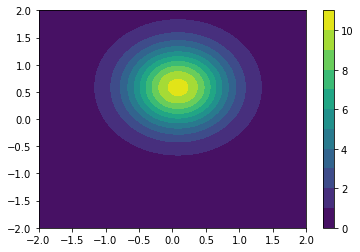

In [17]:
x = np.round(np.linspace(-2,2,101),2)
y = np.round(np.linspace(-2,2,101),2)
X, Y = np.meshgrid(x,y)
Z, x0, y0, fwhm = gaussian_function(X,Y,add_noise=True)
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()

## first full factorial

In [18]:
x_d1 = np.array([0.5,1])
y_d1 = np.array([-0.5,-1])
first_doe = output_model(x_d1, y_d1, pars=(x0, y0, fwhm), cnt_point=False)
first_doe

,x,y,cX,cY,outcome
0,0.5,-0.5,-1.0,1.0,0.867838
1,0.5,-1.0,-1.0,-1.0,0.077232
2,1.0,-0.5,1.0,1.0,0.258828
3,1.0,-1.0,1.0,-1.0,0.023034


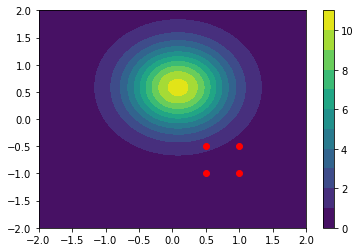

In [19]:
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(first_doe.x,first_doe.y, c='r')

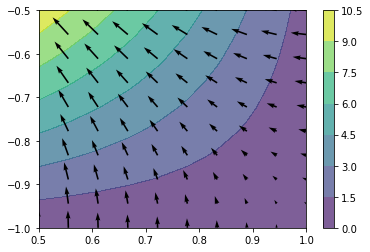

In [20]:
pipe1 = linear_pipe_fit(degree=2, interaction=True, dataframe=first_doe, input_vars=['x','y'])
plot_contour_fromdf(first_doe, fill_value=0, model = pipe1, plot_normal_vars=True)

## Second Step

In [21]:
x_d2, y_d2 = next_step(model=pipe1, increment_y = 2, dataframe=first_doe)
print(x_d2, y_d2)

coef x -2.33 and coef y 2.69
increment x -1.73 and increment y 2.00 with ratio -0.87
new x 0.32 and new y -0.25
[0.19 0.44] [-0.38 -0.12]


coef x -2.20 and coef y 7.57
increment x -0.58 and increment y 2.00 with ratio -0.29
new x 0.24 and new y 0.01
[0.12 0.37] [-0.12  0.14]


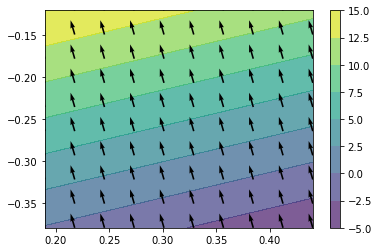

In [22]:
test_df2 = output_model(x_d2, y_d2, model = pipe1, pars=(x0, y0, fwhm), cnt_point=True)
pipe2 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df2, input_vars=['x','y'])
plot_contour_fromdf(test_df2, fill_value=0, model = pipe2)
x_d3, y_d3 = next_step(model=pipe2, increment_y = 2, dataframe=test_df2)
print(x_d3, y_d3)

In [23]:
test_df2

,x,y,cX,cY,outcome,predict,mape
0,0.190,-0.38,-1.0,-1.0,1.819084,1.517726,16.566437
1,0.190,-0.12,-1.0,1.0,3.992976,2.107713,47.214490
2,0.440,-0.38,1.0,-1.0,1.474131,1.146643,22.215634
3,0.440,-0.12,1.0,1.0,3.235789,1.592379,50.788540
4,0.315,-0.25,0.0,0.0,2.573637,1.591115,38.176377


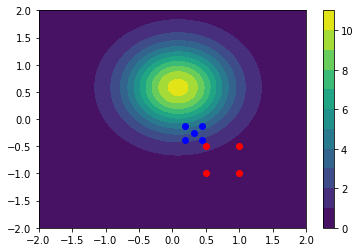

In [24]:
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(first_doe.x,first_doe.y, c='r')
plt.scatter(test_df2.x,test_df2.y, c='b')

## Third Step

coef x -3.02 and coef y 10.46
increment x -0.58 and increment y 2.00 with ratio -0.29
new x 0.17 and new y 0.27
[0.05 0.3 ] [0.15 0.4 ]


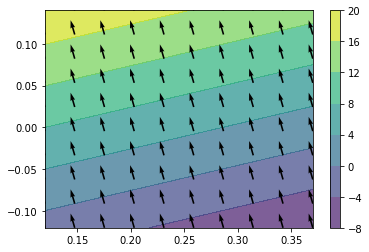

In [25]:
test_df3 = output_model(x_d3, y_d3, pipe2, pars=(x0, y0, fwhm), cnt_point=False)
pipe3 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df3, input_vars=['x','y'])
plot_contour_fromdf(test_df3, fill_value=0, model = pipe3)
x_d4, y_d4 = next_step(model=pipe3, increment_y = 2, dataframe=test_df3)
print(x_d4, y_d4)

In [26]:
test_df3

,x,y,cX,cY,outcome,predict,mape
0,0.12,-0.12,-1.0,-1.0,4.066431,4.032845,0.825919
1,0.12,0.14,-1.0,1.0,6.984177,6.000620,14.082642
2,0.37,-0.12,1.0,-1.0,3.511382,3.481775,0.843149
3,0.37,0.14,1.0,1.0,6.030869,5.449551,9.639049


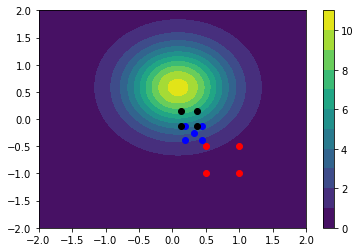

In [27]:
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(first_doe.x,first_doe.y, c='r')
plt.scatter(test_df2.x,test_df2.y, c='b')
plt.scatter(test_df3.x,test_df3.y, c='k')

# Final Implementation

In [36]:
steps_df = pd.DataFrame()
x_t = np.array([0.5,1])
y_t = np.array([-0.5,-1])

for i in range(10):
    test_df = output_model(x_t, y_t, pars=(x0, y0, fwhm), cnt_point=False)
    test_df['iteration'] = i
    pipe1 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df, input_vars=['x','y'])
    x_t, y_t = next_step(pipe1, increment_y = 2, dataframe=test_df)
    #plot_contour_fromdf(test_df, fill_value=0, model = pipe1, plot_normal_vars=True)
    steps_df = steps_df.append(test_df)
    max_outcome = test_df['outcome'].max()
    
    if max_outcome < steps_df['outcome'].max():
        final_ = final_step(model=pipe1, pars=(x0, y0, fwhm), dataframe=test_df)
        final_['iteration'] = i
        pipe_last = linear_pipe_fit(degree=2, interaction=True, dataframe=final_, input_vars=['x','y'])
        steps_df = steps_df.append(final_)
        print(f'maximum found at iteration {i}')
        break
    print(x_t, y_t)

coef x -0.66 and coef y 1.03
increment x -1.29 and increment y 2.00 with ratio -0.65
new x 0.43 and new y -0.25
[0.3  0.55] [-0.38 -0.12]
coef x -2.91 and coef y 6.79
increment x -0.86 and increment y 2.00 with ratio -0.43
new x 0.32 and new y 0.01
[0.19 0.44] [-0.12  0.14]
coef x -4.12 and coef y 9.97
increment x -0.83 and increment y 2.00 with ratio -0.41
new x 0.21 and new y 0.27
[0.09 0.34] [0.15 0.4 ]
coef x -3.72 and coef y 8.66
increment x -0.86 and increment y 2.00 with ratio -0.43
new x 0.11 and new y 0.53
[-0.02  0.23] [0.4  0.65]
coef x -0.74 and coef y 1.98
increment x -0.75 and increment y 2.00 with ratio -0.37
new x 0.01 and new y 0.78
[-0.11  0.14] [0.65 0.9 ]
coef x 2.18 and coef y -6.11
increment x 0.71 and increment y -2.00 with ratio -0.36
new x 0.10 and new y 0.53
[-0.02  0.23] [0.4  0.65]
coef x -0.74 and coef y 1.98
increment x -0.75 and increment y 2.00 with ratio -0.37
new x 0.01 and new y 0.78
coef x -0.74 and coef y 1.98
increment x -0.37 and increment y 1.00 

<AxesSubplot:xlabel='x', ylabel='y'>

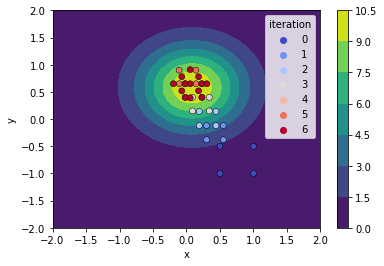

In [37]:
plt.contourf(x,y,Z)
plt.colorbar()
sns.scatterplot(x='x',y='y',data=steps_df, hue='iteration', palette='coolwarm', legend='full', edgecolor='k')

In [40]:
steps_df[steps_df.iteration==6]

,x,y,cX,cY,outcome,iteration
0,-0.020,0.40,-1.0,-1.000000e+00,9.228689,6
1,-0.020,0.65,-1.0,1.000000e+00,9.729453,6
2,0.230,0.40,1.0,-1.000000e+00,9.048302,6
3,0.230,0.65,1.0,1.000000e+00,9.539277,6
0,-0.070,0.52,-0.5,-5.000000e-01,9.513552,6
1,-0.070,0.78,-0.5,5.000000e-01,8.932783,6
2,0.180,0.52,0.5,-5.000000e-01,9.760466,6
3,0.180,0.78,0.5,5.000000e-01,9.164625,6
4,0.055,0.65,0.0,4.270089e-16,9.905114,6
5,0.305,0.65,1.0,4.270089e-16,9.072673,6


In [41]:
pol = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
lr = LinearRegression()
pipe_all = Pipeline([('pol',pol), ('lr', lr)])
pipe_all.fit(steps_df[['x','y']], steps_df['outcome'])
pipe_all['lr'].coef_

array([-0.38960282,  6.1935428 , -2.33025325, -2.5605111 , -1.51669068])

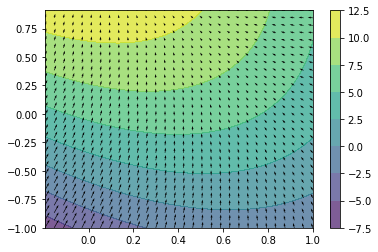

In [42]:
plot_contour_fromdf(steps_df, fill_value=0, model = pipe_all, levels=30)

In [33]:
pipe_all.score(steps_df[['x','y']], steps_df['outcome'])

0.8798263591631788

In [34]:
from sklearn.ensemble import RandomForestRegressor

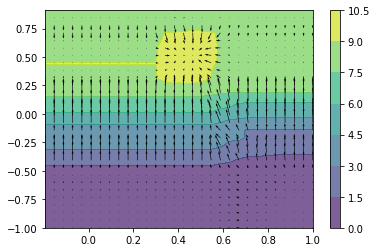

In [35]:
rfr = RandomForestRegressor(max_depth=8)
rfr.fit(steps_df[['x','y']], steps_df['outcome'])
plot_contour_fromdf(steps_df, fill_value=0, model = rfr, levels=30)